In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import uuid
from math import sqrt

In [2]:
INIT_PREDATORS = 75        #Początkowa liczba drapieżników
INIT_PREYS = 150            #Początkowa liczba ofiar
X_MIN = 0
X_MAX = 2
Y_MIN = 0
Y_MAX = 2
global SAFE_DISTANCE
SAFE_DISTANCE = 0.25         #odległość potrzebna do ataku drapieżnika
global PREDATOR_EFFECTIVENESS
PREDATOR_EFFECTIVENESS = 50 #liczba z zakresu od 0-100 określająca szansę na śmierć ofiary w starciu z drapieżnikiem
global MAX_VITALITY
MAX_VITALITY = 30           #wytrzymałość drapieżników (ile rund jest w stanie wytrzymać bez jedzenia)
ITERATIONS = 1000            #liczba iteracji / kroków w błądzeniu losowym, którą symulujemy
global STEP_SIZE
STEP_SIZE = 0.1
global PREY_MULTIPLICATION_RATIO
PREY_MULTIPLICATION_RATIO = 0.01  #o ile % zwiększa się liczebność ofiar w każdej rundzie (liczba z zakresu 0-1)
PREDATOR_MULTIPLICATION_RATIO = 0.01  #o ile % zwiększa się liczebność drapieżników w każdej rundzie (liczba z zakresu 0-1)

In [3]:
class SurfaceBoundaries:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

In [4]:
global surfaceBoundaries
surfaceBoundaries = SurfaceBoundaries(X_MIN, X_MAX, Y_MIN, Y_MAX)

In [5]:
class Position:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        
    def __str__(self):
        return ("Position(" + str(self.x) + ", " + str(self.y) + ")")
    
    def isWithinBoundaries(self) -> bool:
        global surfaceBoundaries
        return (
            surfaceBoundaries.x_min <= self.x <= surfaceBoundaries.x_max 
            and surfaceBoundaries.y_min <= self.y <= surfaceBoundaries.y_max
        )

    def adjust_to_boundaries(self) -> None:
        global surfaceBoundaries
        
        #modelling bouncing from boundaries
        if not self.isWithinBoundaries():
            if self.x < surfaceBoundaries.x_min: 
                delta = surfaceBoundaries.x_min - self.x
                self.x = self.x + 2 * delta
            if self.x > surfaceBoundaries.x_max: 
                delta = self.x - surfaceBoundaries.x_max
                self.x = self.x - 2 * delta
            if self.y < surfaceBoundaries.y_min: 
                delta = surfaceBoundaries.y_min - self.y
                self.y = self.y + 2 * delta
            if self.y > surfaceBoundaries.y_max: 
                delta = self.y - surfaceBoundaries.y_max
                self.y = self.y - 2 * delta
                
    def random_step(self) -> None:
        phi = 2 * np.pi * random.uniform(0, 1)
        self.x += np.cos(phi) * STEP_SIZE
        self.y += np.sin(phi) * STEP_SIZE
        self.adjust_to_boundaries()

def randomPosition() -> Position:
    global surfaceBoundaries
    x = random.uniform(surfaceBoundaries.x_min, surfaceBoundaries.x_max)
    y = random.uniform(surfaceBoundaries.y_min, surfaceBoundaries.y_max)
    return Position(x, y)

def distance(position_a: Position, position_b: Position):
    return sqrt(
        pow(position_a.x - position_b.x, 2) + pow(position_a.y - position_b.y, 2)        
    )

In [6]:
def coin_flip(probability: float) -> bool:
    #accepts probability as number from 0 to 1
    #perform the binomial distribution (returns 0 or 1)    
    return np.random.binomial(1, probability)

def list_to_string(lst: list[object]) -> str:
    string_delimiter = ",\n"
    return string_delimiter.join(str(el) for el in lst)

In [7]:
class Predator:
    def __init__(self):
        global MAX_VITALITY

        self.id = uuid.uuid1()
        self.position = randomPosition()
        self.isAlive = True
        self.vitality = MAX_VITALITY

    def __str__(self):
        return ("Predator(" + 
            str(self.id) + ", " + 
            str(self.position) + ", " + 
            str(self.isAlive) + ", " + 
            str(self.vitality) + 
            ")")

In [8]:
global predators
predators = []
for i in range(INIT_PREDATORS):
    predators.append(Predator())

In [9]:
class Prey:
    def __init__(self):
        self.id = uuid.uuid1()
        self.position = randomPosition()
        self.isAlive = True
        
    def get_endangering_predators(self) -> list[Predator]:
        global predators
        global SAFE_DISTANCE
        
        def are_too_close(predator: Predator, prey: Prey) -> bool:
            return (distance(prey.position, predator.position) < SAFE_DISTANCE)

        return list(filter(lambda predator: are_too_close(self, predator), predators))
        
    def chance_to_die(self, endangering_predators_number: int) -> float:
        global PREDATOR_EFFECTIVENESS
        
        chance_to_survive = pow(((100 - PREDATOR_EFFECTIVENESS) / 100), endangering_predators_number)
        return 1 - chance_to_survive
    
    def __str__(self):
        return ("Prey(" + 
                str(self.id) + ", " + 
                str(self.position) + ", " + 
                str(self.isAlive) +
                ")")

In [10]:
global preys
preys = []
for i in range(INIT_PREYS):
    preys.append(Prey())

In [11]:
global dead_predators
dead_predators = []
global dead_preys
dead_preys = []

In [12]:
def find_endangered_preys_and_attacking_predators():
    global predators
    endangered_preys = list()
    for prey in preys:
        endangering_predators = prey.get_endangering_predators()
        
        if len(endangering_predators) > 0:
            chance_to_die = prey.chance_to_die(len(endangering_predators))
            endangered_preys.append((prey, endangering_predators, chance_to_die))
    return endangered_preys

In [13]:
def mark_predators_meal(happy_predators):
    global predators
    for predator in predators:
        if predator in happy_predators:
            predator.vitality = MAX_VITALITY

In [14]:
def clash_preys_and_predators(endangered_preys):
    for (prey, endangering_predators, chance_to_die) in endangered_preys:
        prey_dies = (coin_flip(chance_to_die) == 1) # == 1 converts 0/1 to False/True
        if prey_dies:
            #print(str(prey) + " got killed by " + str(len(endangering_predators)) + " predators")
            prey.isAlive = False
            mark_predators_meal(endangering_predators)


In [15]:
def decrement_predators_vitality():
    global predators
    for predator in predators:
        predator.vitality = predator.vitality - 1
        if predator.vitality <= 0:
            predator.isAlive = False

In [16]:
def filter_out_dead_predators():
    global predators
    global dead_predators
    
    new_dead_predators = list(filter(lambda predator: (predator.isAlive == False), predators))
    alive_predators = list(filter(lambda predator: (predator.isAlive == True), predators))
    predators = alive_predators
    dead_predators += new_dead_predators    

In [17]:
def filter_out_dead_preys():
    global preys
    global dead_preys
        
    new_killed_preys = list(filter(lambda prey: (prey.isAlive == False), preys))
    alive_preys = list(filter(lambda prey: (prey.isAlive == True), preys))
    preys = alive_preys
    dead_preys += new_killed_preys

In [18]:
def add_new_born_preys():
    global preys
    
    new_preys_number = round(len(preys) * PREY_MULTIPLICATION_RATIO) + 1
    new_preys = []
    for i in range(new_preys_number):
        new_preys.append(Prey())
    preys = preys + new_preys

In [19]:
def add_new_born_predators():
    global predators
    
    new_predators_number = round(len(predators) * PREDATOR_MULTIPLICATION_RATIO) + 1
    new_predators = []
    for i in range(new_predators_number):
        new_predators.append(Predator())
    predators = predators + new_predators

In [20]:
def move_alive_animals_by_one_random_step():
    global predators
    global preys
    
    for predator in predators:
        predator.position.random_step()
    for prey in preys:
        prey.position.random_step()    

In [21]:
def perform_one_iteration():
    endangered_preys = find_endangered_preys_and_attacking_predators()
    clash_preys_and_predators(endangered_preys)
    decrement_predators_vitality()
    filter_out_dead_predators()
    filter_out_dead_preys()
    add_new_born_preys()
    add_new_born_predators()
    move_alive_animals_by_one_random_step()

In [22]:
preys_count_history = []
predators_count_history = []

In [23]:
for i in range(ITERATIONS):
    perform_one_iteration()
    
    print("Iteration " + str(i) + ":")
    print("Dead preys: " + str(len(dead_preys)))
    print("Dead predators: " + str(len(dead_predators)))
    print("Alive preys: " + str(len(preys)))
    print("Alive predators: " + str(len(predators)))
    print()
    
    preys_count_history.append(len(preys))
    predators_count_history.append(len(predators))

Iteration 0:
Dead preys: 124
Dead predators: 0
Alive preys: 27
Alive predators: 77

Iteration 1:
Dead preys: 145
Dead predators: 0
Alive preys: 7
Alive predators: 79

Iteration 2:
Dead preys: 150
Dead predators: 0
Alive preys: 3
Alive predators: 81

Iteration 3:
Dead preys: 152
Dead predators: 0
Alive preys: 2
Alive predators: 83

Iteration 4:
Dead preys: 153
Dead predators: 0
Alive preys: 2
Alive predators: 85

Iteration 5:
Dead preys: 154
Dead predators: 0
Alive preys: 2
Alive predators: 87

Iteration 6:
Dead preys: 156
Dead predators: 0
Alive preys: 1
Alive predators: 89

Iteration 7:
Dead preys: 157
Dead predators: 0
Alive preys: 1
Alive predators: 91

Iteration 8:
Dead preys: 158
Dead predators: 0
Alive preys: 1
Alive predators: 93

Iteration 9:
Dead preys: 159
Dead predators: 0
Alive preys: 1
Alive predators: 95

Iteration 10:
Dead preys: 160
Dead predators: 0
Alive preys: 1
Alive predators: 97

Iteration 11:
Dead preys: 161
Dead predators: 0
Alive preys: 1
Alive predators: 99

I

Iteration 187:
Dead preys: 336
Dead predators: 325
Alive preys: 2
Alive predators: 126

Iteration 188:
Dead preys: 338
Dead predators: 328
Alive preys: 1
Alive predators: 125

Iteration 189:
Dead preys: 339
Dead predators: 331
Alive preys: 1
Alive predators: 124

Iteration 190:
Dead preys: 340
Dead predators: 332
Alive preys: 1
Alive predators: 125

Iteration 191:
Dead preys: 341
Dead predators: 334
Alive preys: 1
Alive predators: 125

Iteration 192:
Dead preys: 342
Dead predators: 334
Alive preys: 1
Alive predators: 127

Iteration 193:
Dead preys: 343
Dead predators: 339
Alive preys: 1
Alive predators: 124

Iteration 194:
Dead preys: 344
Dead predators: 342
Alive preys: 1
Alive predators: 123

Iteration 195:
Dead preys: 345
Dead predators: 345
Alive preys: 1
Alive predators: 122

Iteration 196:
Dead preys: 346
Dead predators: 348
Alive preys: 1
Alive predators: 121

Iteration 197:
Dead preys: 347
Dead predators: 353
Alive preys: 1
Alive predators: 118

Iteration 198:
Dead preys: 348
D

Alive predators: 124

Iteration 338:
Dead preys: 488
Dead predators: 627
Alive preys: 1
Alive predators: 126

Iteration 339:
Dead preys: 489
Dead predators: 628
Alive preys: 1
Alive predators: 127

Iteration 340:
Dead preys: 490
Dead predators: 629
Alive preys: 1
Alive predators: 128

Iteration 341:
Dead preys: 491
Dead predators: 631
Alive preys: 1
Alive predators: 128

Iteration 342:
Dead preys: 492
Dead predators: 632
Alive preys: 1
Alive predators: 129

Iteration 343:
Dead preys: 493
Dead predators: 632
Alive preys: 1
Alive predators: 131

Iteration 344:
Dead preys: 494
Dead predators: 637
Alive preys: 1
Alive predators: 128

Iteration 345:
Dead preys: 495
Dead predators: 638
Alive preys: 1
Alive predators: 129

Iteration 346:
Dead preys: 496
Dead predators: 642
Alive preys: 1
Alive predators: 127

Iteration 347:
Dead preys: 497
Dead predators: 644
Alive preys: 1
Alive predators: 127

Iteration 348:
Dead preys: 498
Dead predators: 646
Alive preys: 1
Alive predators: 127

Iteration 

Iteration 514:
Dead preys: 664
Dead predators: 971
Alive preys: 1
Alive predators: 134

Iteration 515:
Dead preys: 665
Dead predators: 972
Alive preys: 1
Alive predators: 135

Iteration 516:
Dead preys: 666
Dead predators: 973
Alive preys: 1
Alive predators: 136

Iteration 517:
Dead preys: 667
Dead predators: 979
Alive preys: 1
Alive predators: 132

Iteration 518:
Dead preys: 668
Dead predators: 982
Alive preys: 1
Alive predators: 131

Iteration 519:
Dead preys: 669
Dead predators: 984
Alive preys: 1
Alive predators: 131

Iteration 520:
Dead preys: 670
Dead predators: 985
Alive preys: 1
Alive predators: 132

Iteration 521:
Dead preys: 671
Dead predators: 993
Alive preys: 1
Alive predators: 126

Iteration 522:
Dead preys: 672
Dead predators: 993
Alive preys: 1
Alive predators: 128

Iteration 523:
Dead preys: 673
Dead predators: 994
Alive preys: 1
Alive predators: 129

Iteration 524:
Dead preys: 674
Dead predators: 995
Alive preys: 1
Alive predators: 130

Iteration 525:
Dead preys: 675
D

Iteration 640:
Dead preys: 790
Dead predators: 1235
Alive preys: 1
Alive predators: 122

Iteration 641:
Dead preys: 791
Dead predators: 1236
Alive preys: 1
Alive predators: 123

Iteration 642:
Dead preys: 792
Dead predators: 1237
Alive preys: 1
Alive predators: 124

Iteration 643:
Dead preys: 793
Dead predators: 1237
Alive preys: 1
Alive predators: 126

Iteration 644:
Dead preys: 794
Dead predators: 1237
Alive preys: 1
Alive predators: 128

Iteration 645:
Dead preys: 795
Dead predators: 1238
Alive preys: 1
Alive predators: 129

Iteration 646:
Dead preys: 796
Dead predators: 1242
Alive preys: 1
Alive predators: 127

Iteration 647:
Dead preys: 797
Dead predators: 1243
Alive preys: 1
Alive predators: 128

Iteration 648:
Dead preys: 798
Dead predators: 1245
Alive preys: 1
Alive predators: 128

Iteration 649:
Dead preys: 799
Dead predators: 1246
Alive preys: 1
Alive predators: 129

Iteration 650:
Dead preys: 800
Dead predators: 1249
Alive preys: 1
Alive predators: 128

Iteration 651:
Dead p

Iteration 792:
Dead preys: 942
Dead predators: 1523
Alive preys: 1
Alive predators: 138

Iteration 793:
Dead preys: 943
Dead predators: 1524
Alive preys: 1
Alive predators: 139

Iteration 794:
Dead preys: 943
Dead predators: 1525
Alive preys: 2
Alive predators: 140

Iteration 795:
Dead preys: 944
Dead predators: 1527
Alive preys: 2
Alive predators: 140

Iteration 796:
Dead preys: 946
Dead predators: 1533
Alive preys: 1
Alive predators: 136

Iteration 797:
Dead preys: 947
Dead predators: 1535
Alive preys: 1
Alive predators: 136

Iteration 798:
Dead preys: 948
Dead predators: 1537
Alive preys: 1
Alive predators: 136

Iteration 799:
Dead preys: 948
Dead predators: 1541
Alive preys: 2
Alive predators: 134

Iteration 800:
Dead preys: 950
Dead predators: 1544
Alive preys: 1
Alive predators: 133

Iteration 801:
Dead preys: 951
Dead predators: 1546
Alive preys: 1
Alive predators: 133

Iteration 802:
Dead preys: 952
Dead predators: 1547
Alive preys: 1
Alive predators: 134

Iteration 803:
Dead p

Iteration 944:
Dead preys: 1094
Dead predators: 1835
Alive preys: 1
Alive predators: 130

Iteration 945:
Dead preys: 1095
Dead predators: 1837
Alive preys: 1
Alive predators: 130

Iteration 946:
Dead preys: 1096
Dead predators: 1838
Alive preys: 1
Alive predators: 131

Iteration 947:
Dead preys: 1097
Dead predators: 1839
Alive preys: 1
Alive predators: 132

Iteration 948:
Dead preys: 1098
Dead predators: 1845
Alive preys: 1
Alive predators: 128

Iteration 949:
Dead preys: 1099
Dead predators: 1847
Alive preys: 1
Alive predators: 128

Iteration 950:
Dead preys: 1100
Dead predators: 1848
Alive preys: 1
Alive predators: 129

Iteration 951:
Dead preys: 1101
Dead predators: 1851
Alive preys: 1
Alive predators: 128

Iteration 952:
Dead preys: 1102
Dead predators: 1852
Alive preys: 1
Alive predators: 129

Iteration 953:
Dead preys: 1103
Dead predators: 1855
Alive preys: 1
Alive predators: 128

Iteration 954:
Dead preys: 1104
Dead predators: 1862
Alive preys: 1
Alive predators: 123

Iteration 

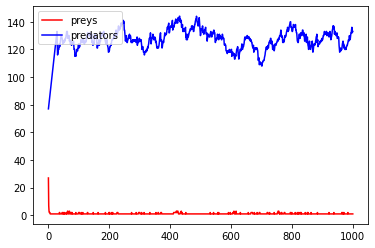

In [24]:
from numpy import *
import math
import matplotlib.pyplot as plt

iterations = linspace(0, ITERATIONS, ITERATIONS)

plt.plot(iterations, preys_count_history, '-r', label="preys") # plotting t, a separately 
plt.plot(iterations, predators_count_history, '-b', label="predators") # plotting t, b separately
plt.legend(loc="upper left")
plt.show()